In [1]:
import os
import glob
import torchvision
from tqdm.auto import tqdm, trange
import mmcv
from mmcv import VideoReader
from typing import List
from utils import makedirs_ifno, imshownp
import data
import numpy as np

# Produce annotation GANTT

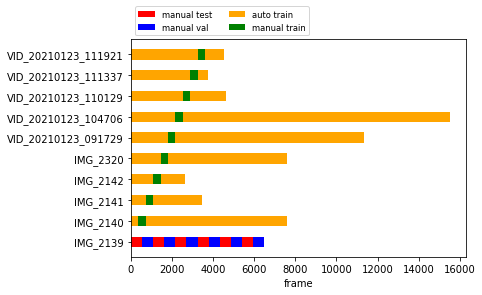

In [61]:
import matplotlib.pyplot as plt
labels = ['IMG_2139']
colname = ['manual test', 'manual val']
color = ['r', 'b']
widths = np.repeat((18*30), 12)
starts  = np.arange(0, 6*36*30, 18*30)
for i in range(2):
    plt.barh(labels[0], widths[i::2], left=starts[i::2], height=0.5,
             label=colname[i], color=color[i])

hand_anno = data.hand_annotated
c = data.ClimbingDataset('all')
labelled = False
for n in list(hand_anno.keys())[1:]:
    width = hand_anno[n].stop - hand_anno[n].start
    vid_idx = data.stripped_names.index(n)
    
    plt.barh(n, len(c.vids[vid_idx]), left=0, height=0.5, color='orange',
             label='auto train' if not labelled else None)
    plt.barh(n, width, left=hand_anno[n].start, height=0.5, color='g',
             label='manual train' if not labelled else None)
    labelled = True

plt.legend(ncol=2, bbox_to_anchor=(0, 1),
           loc='lower left', fontsize='small')
plt.xlabel('frame')
plt.savefig('annotation-gantt.png', bbox_inches='tight', dpi=100)

# Seperate features from hmr_results

In [7]:
res_folder = '/home/tormod/ucph-erda-home/hmr_results'
feat_folder = '/home/tormod/ucph-erda-home/hmr_features'
for name in tqdm(data.stripped_names):
    feat_res = np.load(f'{res_folder}/{name}.npy', allow_pickle=True)
    features = [r['features'] for r in feat_res]
    features = np.stack(features)
    np.save(f'{feat_folder}/{name}.npy', features)

# Saving frames

In [ ]:
input_folder = '/media/tormod/Den\ Lille/Thesis/videos/'
video_names = data.video_names
stripped_names = [v.split('.')[0] for v in video_names] # without .type
video_paths = [input_folder+v for v in video_names]
output_folder = '/media/tormod/Den Lille/Thesis/frames/'

In [10]:
vids = [VideoReader(f, cache_capacity=1) for f in video_paths]

In [ ]:
for frame in [0,2000,5000]:
    imshownp(vids[0][frame], bgr=True, savename=f'first_vid_{frame}.png')

In [11]:
def save_frames(vids: List[VideoReader]):
    for i, v in enumerate(vids):
        vname = stripped_names[i]
        print(f'Processing {vname}...')
        video_folder = f'{output_folder}{vname}/'
        makedirs_ifno([video_folder])
        for j, f in enumerate(tqdm(v)):
            mmcv.imwrite(f, f'{video_folder}{j:06d}.png')

In [12]:
save_frames(vids)

Processing IMG_2320...


# Join MMPose predictions

In [33]:
def load_mmpose_data(path, stop=None):
    files = os.listdir(path)
    files.sort(key=lambda s: int(s.split('.')[0]))
    no_files = stop if stop else len(files)
    files = files[:no_files]
    data = np.zeros((no_files, 17, 3))
    for i, f in tqdm(enumerate(files), total=no_files):
        kp_frame = np.load(path + f, allow_pickle=True)
        if len(kp_frame) > 0:
            kp_frame = kp_frame[0]['keypoints']
            data[i] = kp_frame
    return data

In [ ]:
in_folder = '/home/tormod/ucph-erda-home/mmpose_results'
out_folder = '/home/tormod/ucph-erda-home/mmpose_anno'
makedirs_ifno([out_folder+'/'])
for name in data.stripped_names:
    mmpose_data = load_mmpose_data(f'{in_folder}/{name}/')
    np.save(f'{out_folder}/{name}.npy', mmpose_data)

In [ ]:
np.load('/home/tormod/ucph-erda-home/IMG_2139.npy')

# Process H36M

In [12]:
from scripts import process_h36m
process_h36m.h36m_folder = '/home/tormod/ucph-erda-home/DIKU_Image_Human36M/DatasetSubjects'
process_h36m.h36m_out_folder = '/media/tormod/Den Lille/Thesis/h36m'
subjects = [1,5,6,7,8,9,11]
for sub in subjects:
    process_h36m.save_pose_data(sub)

saving pose data for subject 1


FileNotFoundError: [Errno 2] No such file or directory: '/home/tormod/ucph-erda-home/DIKU_Image_Human36M/DatasetSubjects/annotations/Human36M_subject1_camera.json'